In [1]:
# August, 2022
# Evgenia Galytska (EG), IUP, UB. 
# Original routine is from Kevin Debeire, DLR. 
# This is the modified version of the F1-score calculations, modified for the Arctic-midlatitude research. 

In [2]:
import numpy as np
import collections
from sklearn.metrics import f1_score
import sys
sys.path.append('/home/evgenia/tools/Arctic-midlat/Python_scripts/functions')
from collections import defaultdict #
from calculations import get_metric_f1 as f1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
masking = 'JFM'#, 'DJF', 'JFM']
#sns.set(style="darkgrid")
var_names = ['PV', 'TAS', 'vflux', 'Sib-SLP', 'Ural-SLP','Aleut-SLP', 'NAO', 'U', 'BK-SIC', 'Ok-SIC']
pc_element = 0.01
base_folder = '/home/evgenia/tools/Arctic-midlat/output/PCMCI_plus/dicts_from_PCMCIplus/14072022/'

In [3]:
def put_row_first(df,row_name):
    #put the row_name row at the first position of the df
    df_out=df
    df_out["new"] = range(1,len(df)+1)
    df_out.loc[row_name, 'new'] = 0
    df_out=df_out.sort_values("new").drop('new', axis=1)
    return df_out
def put_column_first(df,column_name):
    #put the column_name col at the first position of the df
    df_out=df
    col= df_out.pop(column_name)
    df_out.insert(0,column_name,col)
    return df_out


In [4]:
dictionary = np.load(base_folder + "1causal_links_historical_10actors_for_f1.npy",allow_pickle='TRUE').item()

df_f1score= {}
score_list =[]
alpha = 0.01

for key1 in dictionary:
    for key2 in dictionary:
        if not (key1 == key2):
            ref_p_matrix= dictionary[key2][masking][pc_element]['results']['p_matrix']
            p_matrix= dictionary[key1][masking][pc_element]['results']['p_matrix']
            ref_val_matrix= dictionary[key2][masking][pc_element]['results']['val_matrix']
            val_matrix= dictionary[key1][masking][pc_element]['results']['val_matrix']
            precision, recall, TP, FP, FN, score, auto, count = f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, 
                        tau_min=0, tau_diff=2, same_sign=True)
            score_list.append([key1,key2,score])
key1,key2,score = [list(a) for a in zip(*score_list)]
df_f1score = pd.DataFrame({"model":key1, "ref_model":key2,"F1-score":score})
df_globalavg= df_f1score.groupby(["ref_model", "model"],as_index=False)["F1-score"].mean()
df_globalavg_pivot= df_globalavg.pivot(index="model",columns="ref_model")["F1-score"]
df_globalavg_pivot= put_row_first(df_globalavg_pivot,"OBS")
df_globalavg_pivot= put_column_first(df_globalavg_pivot,"OBS")

[Text(0, 0.5, 'OBS'),
 Text(0, 1.5, 'ACCESS-CM2'),
 Text(0, 2.5, 'ACCESS-ESM1-5'),
 Text(0, 3.5, 'BCC-CSM2-MR'),
 Text(0, 4.5, 'CAMS-CSM1-0'),
 Text(0, 5.5, 'CMCC-CM2-SR5'),
 Text(0, 6.5, 'CMCC-ESM2'),
 Text(0, 7.5, 'CanESM5'),
 Text(0, 8.5, 'EC-Earth3'),
 Text(0, 9.5, 'EC-Earth3-Veg'),
 Text(0, 10.5, 'EC-Earth3-Veg-LR'),
 Text(0, 11.5, 'GFDL-CM4'),
 Text(0, 12.5, 'GFDL-ESM4'),
 Text(0, 13.5, 'INM-CM4-8'),
 Text(0, 14.5, 'INM-CM5-0'),
 Text(0, 15.5, 'IPSL-CM6A-LR'),
 Text(0, 16.5, 'MIROC6'),
 Text(0, 17.5, 'MPI-ESM1-2-HR'),
 Text(0, 18.5, 'MPI-ESM1-2-LR'),
 Text(0, 19.5, 'MRI-ESM2-0')]

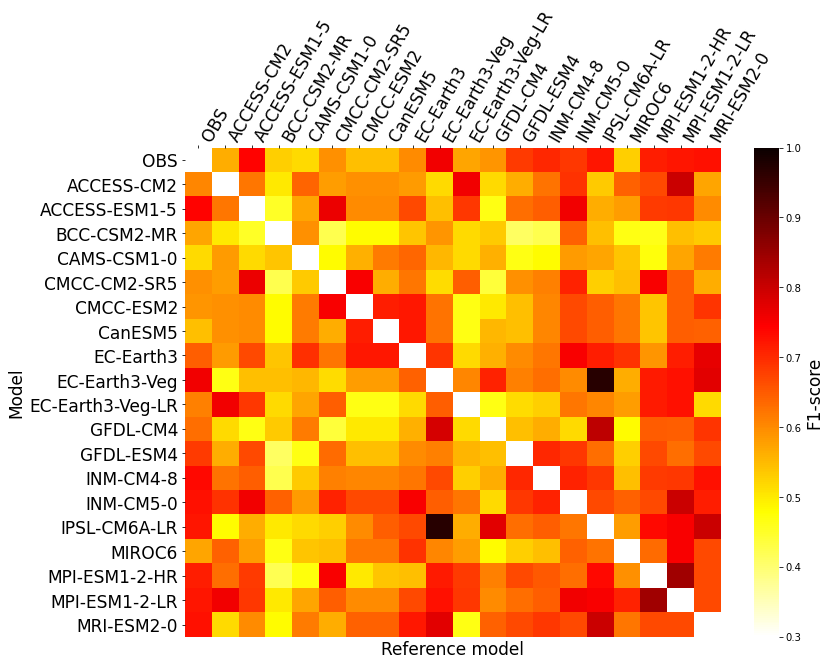

In [5]:
fs = 17
cmap = plt.cm.get_cmap('hot_r')
fig = plt.figure(figsize=(12,9))
g = sns.heatmap(df_globalavg_pivot, cmap=cmap, annot=False, vmin = 0.3, vmax = 1, cbar=True)
g.xaxis.set_ticks_position("top")
g.collections[0].colorbar.set_label("F1-score",fontsize=fs)

#g.set_title('Heatmap of pairwise causal network comparison for OND',fontsize=15,weight="bold")
g.set_xlabel('Reference model',fontsize=fs)
g.set_ylabel('Model',fontsize=fs)
g.set_xticklabels(g.get_xticklabels(), rotation="60",verticalalignment= 'baseline',horizontalalignment= "left", fontsize = fs)
g.set_yticklabels(g.get_yticklabels(), fontsize = fs)